In [65]:
import deepxde as dde
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [66]:
# ==============================================================================
# 1. 환경 설정 및 경로 지정
# ==============================================================================
# DeepXDE는 기본적으로 float32를 권장합니다.
dde.config.set_default_float("float32")

# 파일 경로 설정 (사용자 환경에 맞게 수정해주세요)
BASE_DIR = "C:/Users/admin/Desktop/김도형/코드"
DATA_DIR = os.path.join(BASE_DIR, "Dataset")
MODEL_DIR = os.path.join(BASE_DIR, "model")
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "deepxde_deeponet_model.ckpt")

# 데이터 파일 경로
TRAIN_PATH = os.path.join(DATA_DIR, "darcy_train_32.pt")
TEST_PATH_32 = os.path.join(DATA_DIR, "darcy_test_32.pt")
TEST_PATH_16 = os.path.join(DATA_DIR, "darcy_test_16.pt")
TEST_PATH_64 = os.path.join(DATA_DIR, "darcy_test_64.pt")
TEST_PATH_128 = os.path.join(DATA_DIR, "darcy_test_128.pt")

Set the default float type to float32


In [67]:
# ==============================================================================
# 2. 데이터 로드 및 전처리 (DeepXDE Format 변환)
# ==============================================================================
def load_and_process_data(path, resolution):
    """
    .pt 파일을 읽어 DeepXDE의 CartesianProd 포맷에 맞게 변환합니다.
    - Branch Input: (N_samples, Res*Res) -> 1D Flatten
    - Trunk Input:  (Res*Res, 2) -> (x, y) 좌표
    - Values (u):   (N_samples, Res*Res) -> 1D Flatten
    """
    data = torch.load(path)
    
    # 1. 데이터 추출 (PyTorch Tensor -> Numpy)
    # x: (N, 1, Res, Res) -> (N, Res*Res)
    X_input = data['x'].squeeze().reshape(data['x'].size(0), -1).numpy().astype(np.float32)
    # y: (N, 1, Res, Res) -> (N, Res*Res)
    y_label = data['y'].squeeze().reshape(data['x'].size(0), -1).numpy().astype(np.float32)
    
    # 2. Trunk 좌표 생성 (0~1 사이의 그리드)
    x_lin = np.linspace(0, 1, resolution)
    y_lin = np.linspace(0, 1, resolution)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='ij')
    
    # (Res*Res, 2) 형태로 변환 -> [(0,0), (0,1), ... (1,1)]
    trunk_input = np.vstack((X_grid.flatten(), Y_grid.flatten())).T.astype(np.float32)
    
    return X_input, trunk_input, y_label

print("\nLoading Data...")
# 학습은 32x32 해상도 데이터를 사용한다고 가정
X_train_branch, X_train_trunk, y_train = load_and_process_data(TRAIN_PATH, 32)
X_test_branch,  X_test_trunk,  y_test  = load_and_process_data(TEST_PATH_32, 32)

print(f"Train Branch Shape: {X_train_branch.shape}") # (N, 1024)
print(f"Train Trunk Shape:  {X_train_trunk.shape}")  # (1024, 2)
print(f"Train Label Shape:  {y_train.shape}")        # (N, 1024)


Loading Data...
Train Branch Shape: (5000, 1024)
Train Trunk Shape:  (1024, 2)
Train Label Shape:  (5000, 1024)


C:\Users\admin\AppData\Local\Temp\ipykernel_24412\2286923558.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


In [68]:
# ==============================================================================
# 3. DeepXDE 데이터셋 및 모델 정의
# ==============================================================================
# TripleCartesianProd: (Branch, Trunk)의 조합이 Cartesian Product(격자) 형태일 때 사용
data = dde.data.TripleCartesianProd(
    X_train=(X_train_branch, X_train_trunk),
    y_train=y_train,
    X_test=(X_test_branch, X_test_trunk),
    y_test=y_test
)

# DeepONet (MLP 기반) 구조 정의
# Branch: 1024(입력) -> 128 -> 128 -> 128 (출력)
# Trunk:  2(좌표)    -> 128 -> 128 -> 128 (출력)
net = dde.nn.DeepONetCartesianProd(
    layer_sizes_branch=[1024, 512, 256, 128, 256],
    layer_sizes_trunk=[2, 512, 256, 128, 256],
    activation="relu",
    kernel_initializer="Glorot normal"
)

model = dde.Model(data, net)

Compiling model...
'compile' took 0.000325 s


Starting Training...
Training model...

Step      Train loss    Test loss     Test metric   
0         [2.11e-01]    [2.13e-01]    [8.80e-01]    
1000      [6.06e-03]    [9.32e-03]    [1.88e-01]    
Epoch 1000: train loss improved from inf to 6.06e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_model.ckpt-1000.pt ...

2000      [3.31e-03]    [7.30e-03]    [1.60e-01]    
Epoch 2000: train loss improved from 6.06e-03 to 3.31e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_model.ckpt-2000.pt ...

3000      [3.12e-03]    [7.26e-03]    [1.62e-01]    
Epoch 3000: train loss improved from 3.31e-03 to 3.12e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_model.ckpt-3000.pt ...

4000      [2.10e-03]    [6.58e-03]    [1.50e-01]    
Epoch 4000: train loss improved from 3.12e-03 to 2.10e-03, saving model to C:/Users/admin/Desktop/김도형/코드\model\deepxde_deeponet_model.ckpt-4000.

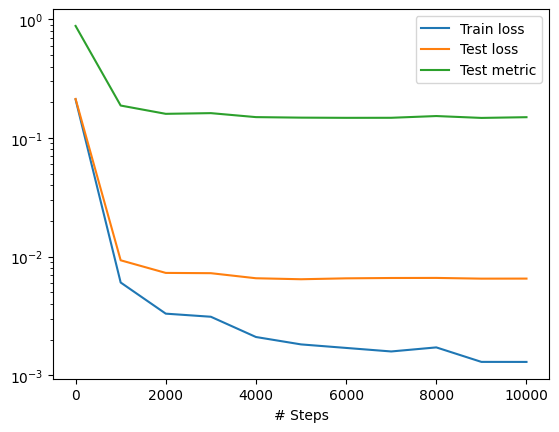

In [69]:
# ==============================================================================
# 4. 모델 학습 (Autosave 포함)
# ==============================================================================
# Optimizer 설정
model.compile("adam", lr=5e-4, metrics=["mean l2 relative error"])

# Callbacks: Autosave (가장 성능 좋은 모델만 저장)
checker = dde.callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH, 
    save_better_only=True, 
    period=1000, 
    verbose=1
)

print("\nStarting Training...")
# iterations는 필요에 따라 조절하세요 (예: 10000 ~ 50000)
losshistory, train_state = model.train(iterations=10000, callbacks=[checker])

# 학습 결과 시각화
dde.saveplot(losshistory, train_state, issave=False, isplot=True)




========== Testing Resolution: 16x16 with DeepXDE ==========
총 테스트 샘플 수: 50
평균 Relative L2 Error: 17.96%


C:\Users\admin\AppData\Local\Temp\ipykernel_24412\1531845631.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_data = torch.load(data_path)


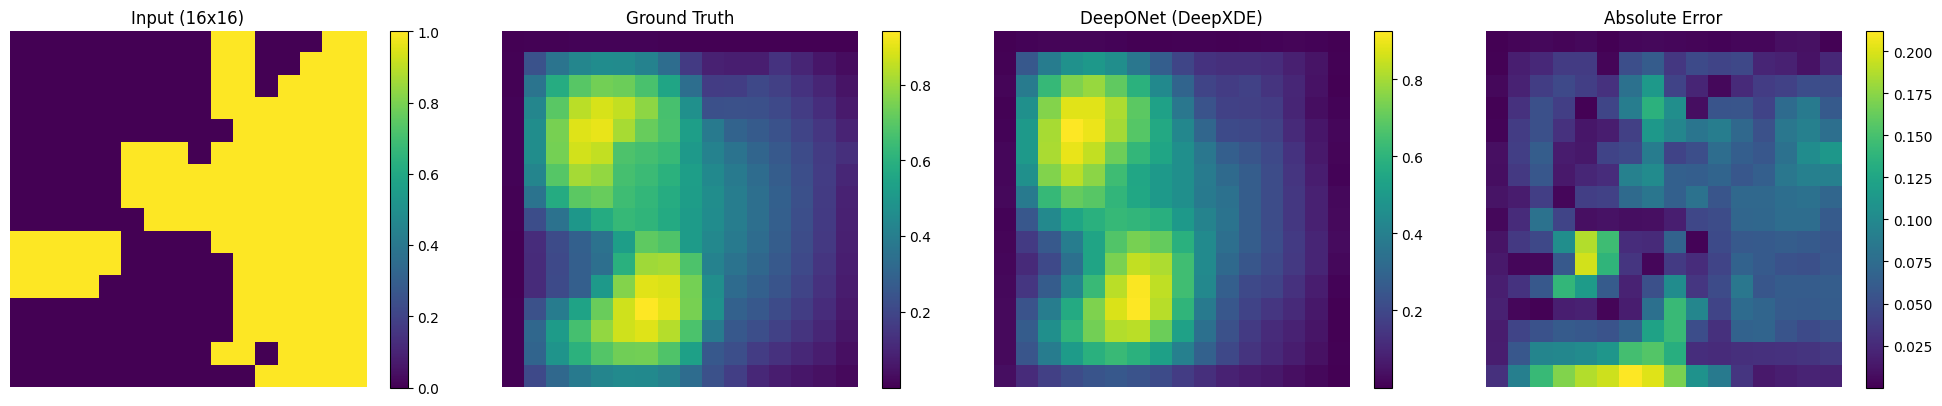


========== Testing Resolution: 32x32 with DeepXDE ==========
총 테스트 샘플 수: 1000
평균 Relative L2 Error: 14.97%


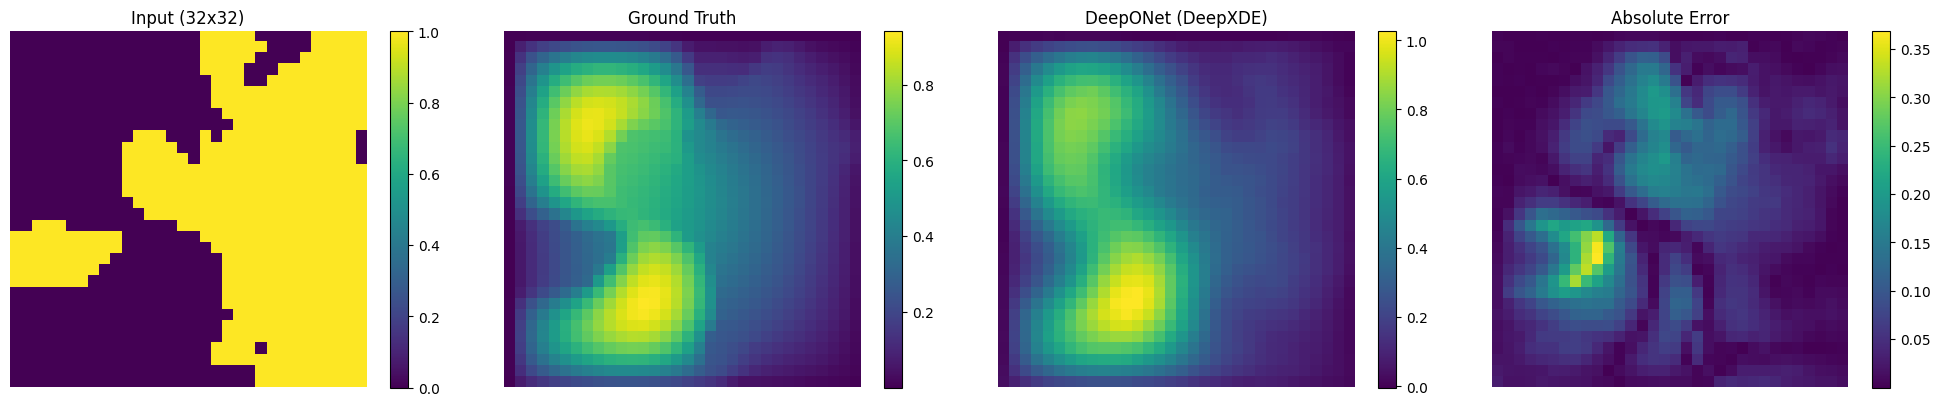


========== Testing Resolution: 64x64 with DeepXDE ==========
총 테스트 샘플 수: 1000
평균 Relative L2 Error: 15.82%


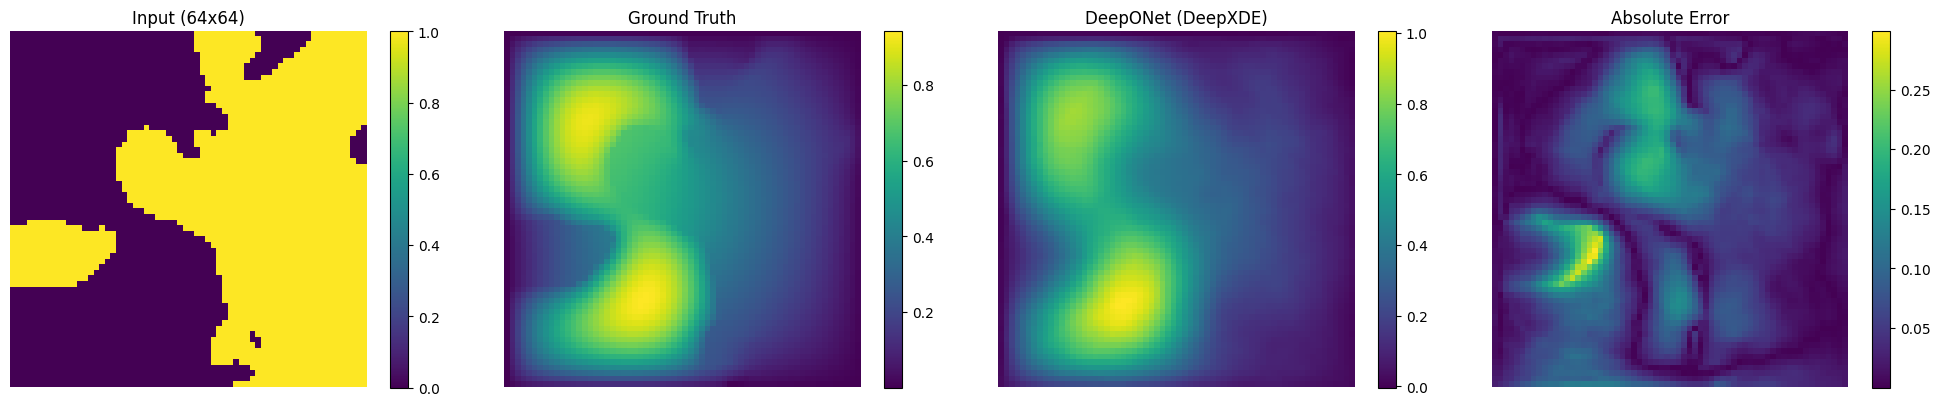

In [73]:
# ==============================================================================
# 5. 다른 해상도 (16, 64) 검증 및 시각화
# ==============================================================================
def test_resolution_deepxde(resolution, data_path, model):
    print(f"\n========== Testing Resolution: {resolution}x{resolution} with DeepXDE ==========")
    
    # 1. 데이터 로드 (Raw Data)
    raw_data = torch.load(data_path)
    x_raw = raw_data['x'] 
    y_raw = raw_data['y'] 
    
    # [수정] 데이터 타입 강제 변환 (Bool/Int -> Float32)
    # 보간(Interpolation)을 위해서는 반드시 실수형이어야 합니다.
    x_raw = x_raw.float() 
    y_raw = y_raw.float()
    
    # 차원 확인 및 보정: (N, Res, Res) -> (N, 1, Res, Res)
    if x_raw.dim() == 3:
        x_raw = x_raw.unsqueeze(1)
    if y_raw.dim() == 3:
        y_raw = y_raw.unsqueeze(1)
    
    # 2. Branch Input 준비 (Interpolation)
    # DeepONet Branch는 32x32(1024 dim)으로 학습되었으므로, 입력도 32x32로 맞춰야 함
    if resolution != 32:
        x_interp = F.interpolate(x_raw, size=(32, 32), mode='bilinear', align_corners=False)
    else:
        x_interp = x_raw
        
    # DeepXDE 입력용으로 Flatten (N, 1024)
    X_branch = x_interp.reshape(x_interp.size(0), -1).numpy()
    
    # 3. Trunk Input 준비 (Target Resolution 좌표)
    x_lin = np.linspace(0, 1, resolution)
    y_lin = np.linspace(0, 1, resolution)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin, indexing='ij')
    X_trunk = np.vstack((X_grid.flatten(), Y_grid.flatten())).T
    
    # 4. DeepXDE 모델 예측
    # predict의 입력은 (Branch_data, Trunk_data) 튜플입니다.
    y_pred_flat = model.predict((X_branch, X_trunk))
    
    # 5. 오차 계산 및 시각화용 데이터 준비
    # 정답 데이터 Flatten
    y_true_flat = y_raw.reshape(y_raw.size(0), -1).numpy()
    
    diff_norm = np.linalg.norm(y_pred_flat - y_true_flat, axis=1)
    true_norm = np.linalg.norm(y_true_flat, axis=1)
    l2_errors = diff_norm / (true_norm + 1e-6)
    
    avg_error = np.mean(l2_errors)
    
    # 결과 텍스트 출력
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    # formatted_errors = [f"{e*100:05.2f}%" for e in l2_errors[:20]] 
    # print(f"샘플별 오차(상위 20개): {formatted_errors} ...")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")
    
    # 6. 시각화 (첫 번째 샘플)
    idx = 0
    vis_input = x_raw[idx, 0].numpy()
    vis_true  = y_raw[idx, 0].numpy()
    vis_pred  = y_pred_flat[idx].reshape(resolution, resolution)
    vis_error = np.abs(vis_true - vis_pred)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    titles = [f'Input ({resolution}x{resolution})', 'Ground Truth', 'DeepONet (DeepXDE)', 'Absolute Error']
    images = [vis_input, vis_true, vis_pred, vis_error]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_don_xde_mlp_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 저장된 최적 모델 가중치 다시 로드 (Autosave된 파일)
# 주의: DeepXDE는 체크포인트 파일명 뒤에 "-숫자.ckpt"가 붙을 수 있습니다.
model.restore("C:/Users/admin/Desktop/김도형/코드/model/deepxde_deeponet_model.ckpt-10000.pt")

# 테스트 실행
test_resolution_deepxde(16, TEST_PATH_16, model)
test_resolution_deepxde(32, TEST_PATH_32, model)
test_resolution_deepxde(64, TEST_PATH_64, model)